# Parameter Estimation in the Passive Neuronal Model #



In [3]:
import numpy as np
import scipy.io as spio
from scipy.integrate import solve_ivp
##%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
rcParams['font.size'] = 18
rc('font', family='sans-serif')
rcParams['font.family'] = 'Serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
# changed to False because I am not using LaTex
rcParams['text.usetex'] = False

In [4]:
# constants
Cm = 1.0    # Membrane Capcitance uF/cm^2
VCl = -68 # mv Cl reversal potential
gCl = 0.3  # mS/cm^2 Cl conductance 
tau=Cm/gCl
A=4*np.pi*1e-6

# Cl leak current
def IlCl(V):
    return (VCl-V)/tau

# Stimulus current 10pA (10-5 mA)
def Istim(t):
    if t>2 and t<22:
        Istim = 1e-5
    else:
        Istim=0
    return Istim

    
#Passive neuronal model ODE
def PNM(t, y):
    V = y
    dVdt = (IlCl(V) + Istim(t) / (A * Cm))
    return [ dVdt ]


In [5]:
# initial values
V0 = VCl

# Solve PN model
# did not do continuous function because it was giving weird kinks
t_span = [0, 100]
sol = solve_ivp(PNM, t_span, [V0])

# select timepoints
t_fe_step = 2
t_meas = [sol.t[i] for i in range(1, len(sol.t), t_fe_step)]
V_meas = [sol.y[0,i] for i in range(1, len(sol.t), t_fe_step)]
display(t_meas)

print("\n\n Measurements" )
print(" number of subintervals = {0:d}".format(len(sol.t)-1) )
print(" number of measurements = {0:d}".format(len(t_meas)) )

[1e-06,
 0.00011099999999999999,
 0.011111,
 1.1111109999999997,
 6.855280331557182,
 20.60563169494327,
 28.596983386538653,
 42.21865280245139,
 66.24532330753678,
 87.60379198463602,
 100.0]



 Measurements
 number of subintervals = 21
 number of measurements = 11


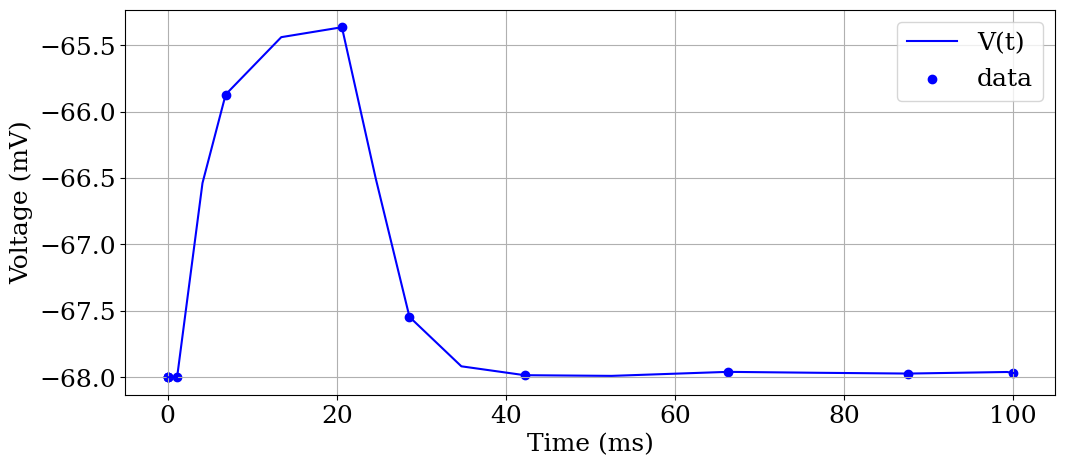

In [6]:
# Plot solution
fig1 = plt.figure(figsize=(12,5))
plt.plot(sol.t, sol.y[0, :], 'b', label='V(t)')
plt.scatter(t_meas, V_meas, c='b', label='data')
plt.ylabel('Voltage (mV)')
plt.xlabel('Time (ms)')
plt.legend(loc='upper right')
plt.grid()


## Parameter Estimation



In [7]:
import pyomo.environ as pyo
import pyomo.dae as dae

# creating model 
model = pyo.ConcreteModel()

# time horizon
model.t = dae.ContinuousSet(bounds=(0,100), initialize=t_meas)  # include measurement times indiscretization

# time-dependent variables
model.V = pyo.Var(model.t, bounds=(-68,-60))
model.dV = dae.DerivativeVar(model.V, wrt = model.t)

# initial conditions
model.V[0].fix(-68)

# parameters, initialized to arbitrary values
# changed the bounds to be more realistic
model.tau = pyo.Var(domain=pyo.Reals, initialize=3, bounds=(1,30))   # ms time constant 
model.Cm = pyo.Var(domain=pyo.Reals, initialize=0.5, bounds=(0.25, 5))  # uF/cm^2 membrane capacitance 

#time dependent parameter, deleted V from the last parameter
def Istim_rule(model, t):
    if t>2 and t<22:
        return 10e-5
    else:
        return 0.0

#parametrize the current, removed the second "model.t" which was unnecessary because only 1-D
model.Istim = pyo.Param(model.t, initialize=Istim_rule)



In [8]:
# ODE constraints defined
def PNM_V(m, t):
    if t == m.t.first():
        return pyo.Constraint.Skip  # Skip constraint at t=0
    V = (m.V[t])
    tau, Cm = (m.tau, m.Cm)
    dVdt = (IlCl(V) + Istim(t) / (A * Cm))

    return m.dV[t]==dVdt 


# constraints
model.ode_V = pyo.Constraint(model.t, rule=PNM_V)

# discretization, converting high level constraints into algebraic constraints (algebraic relationship) 
discretizer = pyo.TransformationFactory('dae.finite_difference')
# over 2000 steps using backwards Euler
discretizer.apply_to(model, nfe=2000, scheme='BACKWARD') 

In [9]:
# measurement indices
i_meas = np.zeros(len(t_meas), dtype=int)  
for k in range(len(t_meas)):
    i_meas[k] = model.t.find_nearest_index(t_meas[k])
    
# Objective function
# sum of differences squared (model should have minimum res)
def objective_rule(m):
    res = 0
    for (i,j) in enumerate(i_meas):
        res += (m.V[m.t.at(j)]-V_meas[i])**2     # Minimize difference in V 
    return res

#default value of minimizing
model.obj_fun = pyo.Objective(rule=objective_rule)

# initialize V_s
# sets the data points that we know to the corresponding subset of the 2000 pts
for (i,j) in enumerate(i_meas):
    if model.t.at(j) == 0: continue    # already have initial condition, skips next line
    model.V[model.t.at(j)] = V_meas[i]
# check that the values are initialized
model.display()

Model unknown

  Variables:
    V : Size=2001, Index=t
        Key                    : Lower : Value              : Upper : Fixed : Stale : Domain
                             0 :   -68 :                -68 :   -60 :  True : False :  Reals
                         1e-06 :   -68 :              -68.0 :   -60 : False : False :  Reals
        0.00011099999999999999 :   -68 :              -68.0 :   -60 : False : False :  Reals
                      0.011111 :   -68 :              -68.0 :   -60 : False : False :  Reals
                      0.079861 :   -68 :               None :   -60 : False :  True :  Reals
                      0.148611 :   -68 :               None :   -60 : False :  True :  Reals
                      0.217361 :   -68 :               None :   -60 : False :  True :  Reals
                      0.286111 :   -68 :               None :   -60 : False :  True :  Reals
                      0.354861 :   -68 :               None :   -60 : False :  True :  Reals
               

In [10]:
# Solve using ipopt
solver = pyo.SolverFactory('ipopt')
results = solver.solve(model, tee=True) 

Ipopt 3.14.11: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    10386
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       12

Total number of variables............................:     4001
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2001
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4000
Total number



True parameters:
 tau = 3.3333e+00 
 Cm = 1.0000e+00
Computed parameters:
 tau = 3.0000e+00 
 Cm = 9.8186e-01


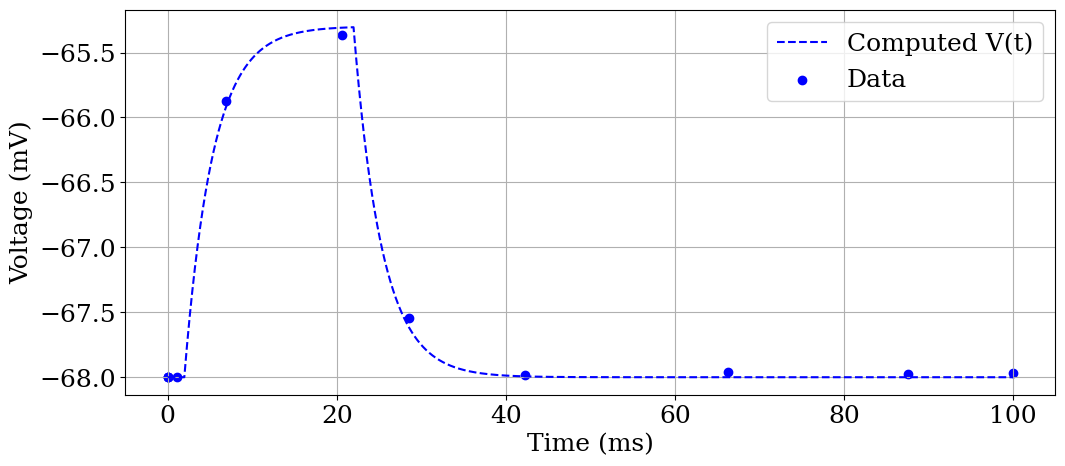

In [9]:
# print optimal solution
print("\n")
print("True parameters:")
print(" tau = {0:10.4e} \n Cm = {1:10.4e}".format(tau, Cm))
print("Computed parameters:")
print(" tau = {0:10.4e} \n Cm = {1:10.4e}".format(model.tau(), model.Cm()))

t_sim = [t for t in model.t]
V_sim = [model.V[t]() for t in model.t]


# plot
fig1 = plt.figure(figsize=(12,5))
# dotted line represents optimized equation against the true data points
plt.plot(t_sim, V_sim, 'b--', label='Computed V(t)')
plt.scatter(t_meas, V_meas, c='b', label='Data')
plt.ylabel('Voltage (mV)')
plt.xlabel('Time (ms)')
plt.legend(loc='upper right')
plt.grid()
